<font size="5">**Connecting to the database**</font>
<br /><br />
<font size="3">First, we import the necessary libraries.</font>

In [4]:
#!pip install tqdm
#!pip install opencv-python
#!pip install matplotlib
#!pip install scipy
import mysql.connector as mysql
import database as db
import csv, sys
import image_generator
import feature_extractor
import numpy as np
import os
#os.environ["CUDA_VISIBLE_DEVICES"]="-1"    
#!unset CUDA_VISIBLE_DEVICES

<font size="3">Now, we establish the connection.</font>

In [5]:
myDB = db.connect_db("inference")
list_model = ["mobilenet_v1", "inception_v4", "resnet_v1_152"]

<font size="5">**Extracting the features**</font>

<font size="3">We start the *image generator* class and choose the range of images.</font>

In [6]:
image_generator.main()
imgGen = image_generator.ImageGenerator('images/val/images', 'images/val/val.txt', 'images/val/synset_words.txt')
label_list = imgGen.get_label_list() 

images/val/images\ILSVRC2012_val_00026933.JPEG barbell
images/val/images\ILSVRC2012_val_00048866.JPEG planetarium
images/val/images\ILSVRC2012_val_00019604.JPEG trifle
images/val/images\ILSVRC2012_val_00024206.JPEG Yorkshire terrier
images/val/images\ILSVRC2012_val_00008016.JPEG hand-held computer, hand-held microcomputer
images/val/images\ILSVRC2012_val_00014032.JPEG Gordon setter
images/val/images\ILSVRC2012_val_00038813.JPEG bikini, two-piece
images/val/images\ILSVRC2012_val_00032139.JPEG sea slug, nudibranch
images/val/images\ILSVRC2012_val_00040766.JPEG black-footed ferret, ferret, Mustela nigripes
images/val/images\ILSVRC2012_val_00024053.JPEG toy terrier


In [7]:
img_nums = []
for i in range(1, 200):                 # the range of images can be selected here
    img_nums.append(i)

img_paths = []
filenames = []
for i in range(len(img_nums)):
    img_path, _ = imgGen.get_image_data(img_nums[i])
    img_paths.append(img_path)                                             # we obtain the image paths and filenames
for i in range(len(img_nums)):
    img_name = imgGen.get_image_filename(img_nums[i])
    filenames.append(img_name)

<font size="3">Extracting the <font color="green">seven</font> selected features from the images.</font>

199


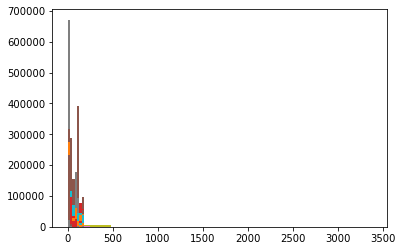

In [8]:
features_list = []                            # this list hold features of all 20k images

for i in range(len(img_paths)):
    filename = img_paths[i]
    features_list.append(feature_extractor.extract_features(filename))
print(len(features_list))

<font size="3">Normalizing and standardizing the data.</font>

In [9]:
#import sklearn.preprocessing as preprocessing
#features_list1 = np.asarray(features_list)
#min_max_scaler = preprocessing.MinMaxScaler(feature_range = (0, 1))        # scaling of features 0-1
#features_list1 = min_max_scaler.fit_transform(features_list1)

In [10]:
import sklearn.preprocessing as preprocessing

features_list = preprocessing.normalize(features_list)
features_list = preprocessing.scale(features_list)

In [11]:
myDB = db.connect_db("inference")
list_model = ["mobilenet_v1", "inception_v4", "resnet_v1_152"]

<font size="5">**Determining the best <font color="green">top-1</font> and <font color="green">top-5</font> model for each image**</font>

<font size="3">Connecting to the <font color="green">database</font> to determine the best top-1 and top-5 models for each image.</font>

In [12]:
best_top_1 = []
best_top_5 = []
list_model = ["mobilenet_v1", "inception_v4", "resnet_v1_152"]
for i in range(len(img_nums)):

    best_top_1.append(db.determine_best_top_n_model("inference", img_nums[i], list_model, 1))  # best top-1 model for the image

    best_top_5.append(db.determine_best_top_n_model("inference", img_nums[i], list_model, 5))  # best top-5 model for the image

In [12]:
top_1_best_models = []              # appending the values representing the best top-1 model
for i in range(len(best_top_1)):
    if best_top_1[i] == 'mobilenet_v1':
        top_1_best_models.append([1, 0, 0])
    elif best_top_1[i] == 'inception_v4':
        top_1_best_models.append([0, 1, 0])
    elif best_top_1[i] == 'resnet_v1_152':
        top_1_best_models.append([0, 0, 1])
    elif best_top_1[i] == 'failed':
        top_1_best_models.append([0, 0, 0])

<font size="5">**Writing the data to a csv file**</font>
<br /><br />
<font size="3">Creating the best <font color="green">top-1</font> model csv.</font>

In [13]:
filename = 'all_new_features_hier_norm_top_1.csv'
with open('all_new_features_hier_norm_top_1.csv', mode='w', newline='') as featuresFile1:
    features_writer = csv.writer(featuresFile1, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)

    features_writer.writerow(['filename', 'Mobilenet_v1', 'Inception_v4', 'Resnet_v1_152', 'kp_surf',
                              'average_perceived_brightness', 'contrast', 'area_by_perim', 'aspect_ratio', 'edge_length1', 
                             'hue1'])
    for i in range(len(features_list)):
        row = ([filenames[i], top_1_best_models[i][0], top_1_best_models[i][1], top_1_best_models[i][2], features_list[i][0], features_list[i][1], features_list[i][2],
               features_list[i][3], features_list[i][4], features_list[i][5], features_list[i][6]])
        features_writer.writerow(row)

<font size="3">Completing the same operation for <font color="green">top-5</font>.</font>

In [14]:
top_5_best_models = []                                        # this part is for the best top 5 model
for i in range(len(best_top_5)):
    if best_top_5[i] == 'mobilenet_v1':
        top_5_best_models.append([1, 0, 0])
    elif best_top_5[i] == 'inception_v4':
        top_5_best_models.append([0, 1, 0])
    elif best_top_5[i] == 'resnet_v1_152':
        top_5_best_models.append([0, 0, 1])
    elif best_top_5[i] == 'failed':
        top_5_best_models.append([0, 0, 0])

In [15]:
filename = 'all_new_features_hier_norm_top_5.csv'
with open('all_new_features_hier_norm_top_5.csv', mode='w', newline='') as featuresFile2:
    features_writer = csv.writer(featuresFile2, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)

    features_writer.writerow(['filename', 'Mobilenet_v1', 'Inception_v4', 'Resnet_v1_152', 'kp_surf',
                              'average_perceived_brightness', 'contrast', 'area_by_perim', 'aspect_ratio', 'edge_length1', 
                             'hue1'])
    for i in range(len(features_list)):
        row = ([filenames[i], top_5_best_models[i][0], top_5_best_models[i][1], top_5_best_models[i][2], features_list[i][0], features_list[i][1], features_list[i][2],
               features_list[i][3], features_list[i][4], features_list[i][5], features_list[i][6]])
        features_writer.writerow(row)